# Business Problem

Syria Tel is a telecom company that is reaching out to us to reduce customers leaving their service for another provider (defined as churn). To do this we will analyze information and create a model that will predict if a customer is at risk of leaving, as well as try to determine what factors are causing customrs to want to leave.


In [8]:
import warnings

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# from dtreeviz.trees import dtreeviz
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Set Random Seed
np.random.seed(1989)

# Remove warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [9]:
data = pd.read_csv('./Churn_Telecom.csv')
data.head(20)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False


In [10]:
# Rename columns, replace space with underscore
new_columns = [i.replace(' ', '_') for i in data.columns]
data.columns = new_columns
data

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [12]:
data.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


AttributeError: 'AxesSubplot' object has no attribute 'sns'

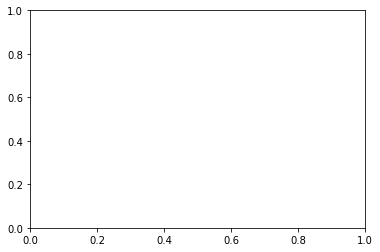

<Figure size 1440x504 with 0 Axes>

In [13]:
# Calculate No. of Customers by State by Churn Status
# Create a Pivot Table to Plot, rename columns and sort values
to_plot = data.pivot_table(index='state', columns='churn', values='area_code', aggfunc='count').reset_index()
to_plot.columns = ['state', 'false', 'true']
to_plot = to_plot.sort_values('true', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(20,7))

# Two bar charts
s1 = sns.barplot(x = 'state', y = 'false', data = to_plot, color = 'blue', alpha=0.7, label='No')
s2 = sns.barplot(x = 'state', y = 'true', data = to_plot, color = 'red', alpha=0.9, label='Yes')

# Title, labels and legend
plt.title('No. of Customers by State', size=16)
plt.ylabel('No. of Customers', size=15)
plt.xlabel(None)
plt.legend(title='Churned?', prop={'size': 12}, title_fontsize=12)

plt.show();

After initial review of data, we see some good things about the data:
1. There are no missing values.
2. There do not appear to be outliers

However, there is something odd about area_code. From the head we can only see 3 different area codes, and the describe function seems to also suggest only 3 area codes are available. This does not make sense givent the diversity of states, and if we can confirm that there are only 3 area codes, we will have to drop the column based on the data being unreliable.

In [7]:
data['area_code'].value_counts()

415    1655
510     840
408     838
Name: area_code, dtype: int64

In [8]:
data['state'].unique().shape

(51,)

We can confirm that the area code data is unreliable (there should be far more area codes when all states are covered. We are going to drop area code as well as phone number since phone number should not have any bearing on customer retention.

In [9]:
data.drop(['phone_number', 'area_code'], axis=1, inplace=True)

The rest of the columns should now be relevant, so we can dive deeper into EDA before starting to build our model. We can start by getting an idea of what features seem to be related to our target, as well as identifying any issues with multicollinearity. 

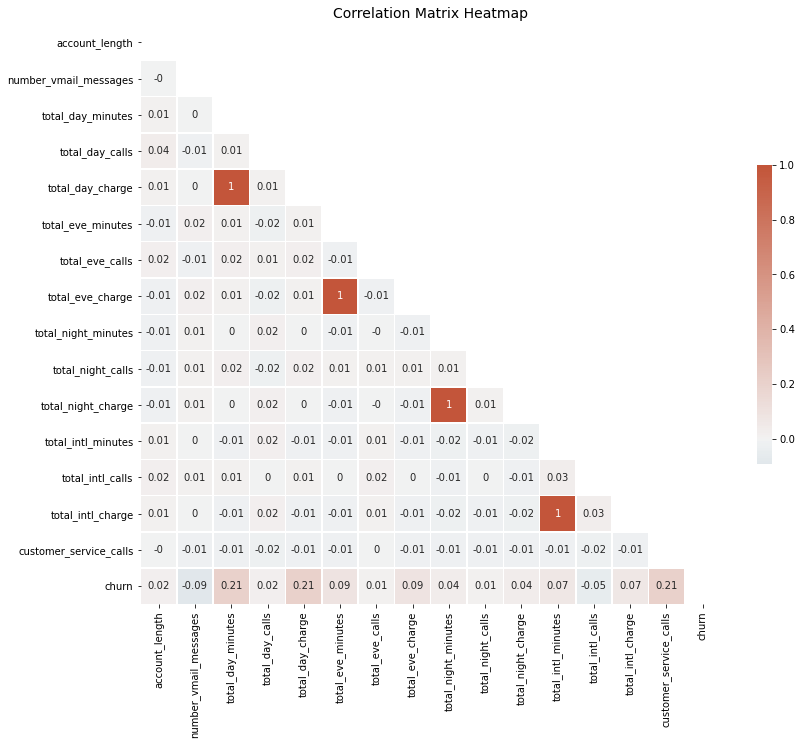

In [10]:
# Correlation numbers
corr = data.corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Title
plt.title('Correlation Matrix Heatmap', size=14);

We can see that churn seems to be related to customer_service_calls, total_day_charge, and total_eve_charge. That may be something to look out for in our final model.

We can also see that there are 4 where features are fully related, which are the total_x_minutes and total_x_charge (which would make sense). To avoid multicollinearity, we will drop the total_x_minutes columns.

In [11]:
data.drop(['total_intl_minutes', 'total_night_minutes', 'total_eve_minutes', 'total_day_minutes'], axis=1, \
         inplace=True)

Next we want to pre-process our data. There are two parts to this:
1. We want to have our categorical data (such as state) be used by our models. To do so, we can use OneHotEncoder to change them to numeric representations of true or false (ie if a customer lives in Illinois, there will be an Illinois column set to 1 while all other state columns are set to 0.
2. We want all numeric data on the same scale. Account length will naturally have lower numbers than total day minutes, since it is easier to accrue minutes than months. In preprocessing we will use StandardScaler to change numbers to be between 0 and 1, relative to other numbers in the column so higher numbered columns do not influence our model moret than they should.

In [12]:
X = data.drop("churn", axis=1)
y = data.churn

In [13]:
cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

In [14]:
X_num = X[num_cols]
X_cat = X[cat_cols]

In [15]:
ohe = OneHotEncoder()

ohe = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

X_cat_ohe = pd.DataFrame(ohe.fit_transform(X_cat), \
                               columns=ohe.get_feature_names(X_cat.columns) ,index=X_cat.index)

In [16]:
X_cat_ohe

,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international_plan_yes,voice_mail_plan_yes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3331,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
X_merged = pd.concat([X_num, X_cat_ohe], axis=1)
X_merged

,account_length,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international_plan_yes,voice_mail_plan_yes
0,128,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,107,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,137,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,84,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,75,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,36,77,26.55,126,18.32,83,12.56,6,2.67,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3329,68,0,57,39.29,55,13.04,123,8.61,4,2.59,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3330,28,0,109,30.74,58,24.55,91,8.64,6,3.81,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3331,184,0,105,36.35,84,13.57,137,6.26,10,1.35,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
scaler = StandardScaler()

X_final = pd.DataFrame(scaler.fit_transform(X_merged), \
                               columns=(X_merged.columns) ,index=X_merged.index)

X_final

,account_length,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,international_plan_yes,voice_mail_plan_yes
0,0.676489,1.234883,0.476643,1.567036,-0.055940,-0.070427,-0.465494,0.866029,-0.601195,-0.085690,-0.427932,-0.156821,-0.129532,-0.139921,-0.101519,-0.142134,-0.150686,-0.128329,-0.136539,-0.138802,-0.128329,-0.127116,-0.115663,-0.149642,-0.133079,-0.147532,6.827466,-0.134241,-0.124657,-0.141031,-0.146467,-0.137675,-0.149642,-0.160792,-0.138802,-0.141031,-0.144315,-0.144315,-0.137675,-0.136539,-0.130724,-0.144315,-0.137675,-0.142134,-0.159808,-0.154800,-0.136539,-0.1548,-0.116988,-0.141031,-0.135395,-0.135395,-0.127116,-0.14859,-0.14859,-0.153781,-0.149642,-0.142134,-0.1548,-0.181240,-0.153781,-0.327580,1.617086
1,0.149065,1.307948,1.124503,-0.334013,0.144867,-0.107549,0.147825,1.059390,-0.601195,1.241169,-0.427932,-0.156821,-0.129532,-0.139921,-0.101519,-0.142134,-0.150686,-0.128329,-0.136539,-0.138802,-0.128329,-0.127116,-0.115663,-0.149642,-0.133079,-0.147532,-0.146467,-0.134241,-0.124657,-0.141031,-0.146467,-0.137675,-0.149642,-0.160792,-0.138802,-0.141031,-0.144315,-0.144315,-0.137675,-0.136539,-0.130724,-0.144315,-0.137675,-0.142134,-0.159808,6.459936,-0.136539,-0.1548,-0.116988,-0.141031,-0.135395,-0.135395,-0.127116,-0.14859,-0.14859,-0.153781,-0.149642,-0.142134,-0.1548,-0.181240,-0.153781,-0.327580,1.617086
2,0.902529,-0.591760,0.675985,1.168464,0.496279,-1.573900,0.198935,-0.755571,0.211534,0.697156,-1.188218,-0.156821,-0.129532,-0.139921,-0.101519,-0.142134,-0.150686,-0.128329,-0.136539,-0.138802,-0.128329,-0.127116,-0.115663,-0.149642,-0.133079,-0.147532,-0.146467,-0.134241,-0.124657,-0.141031,-0.146467,-0.137675,-0.149642,-0.160792,-0.138802,-0.141031,-0.144315,-0.144315,-0.137675,-0.136539,-0.130724,6.929264,-0.137675,-0.142134,-0.159808,-0.154800,-0.136539,-0.1548,-0.116988,-0.141031,-0.135395,-0.135395,-0.127116,-0.14859,-0.14859,-0.153781,-0.149642,-0.142134,-0.1548,-0.181240,-0.153781,-0.327580,-0.618396
3,-0.428590,-0.591760,-1.466936,2.196759,-0.608159,-2.743268,-0.567714,-0.078806,1.024263,-1.306401,0.332354,-0.156821,-0.129532,-0.139921,-0.101519,-0.142134,-0.150686,-0.128329,-0.136539,-0.138802,-0.128329,-0.127116,-0.115663,-0.149642,-0.133079,-0.147532,-0.146467,-0.134241,-0.124657,-0.141031,-0.146467,-0.137675,-0.149642,-0.160792,-0.138802,-0.141031,-0.144315,-0.144315,-0.137675,-0.136539,-0.130724,-0.144315,-0.137675,-0.142134,-0.159808,6.459936,-0.136539,-0.1548,-0.116988,-0.141031,-0.135395,-0.135395,-0.127116,-0.14859,-0.14859,-0.153781,-0.149642,-0.142134,-0.1548,-0.181240,-0.153781,3.052685,-0.618396
4,-0.654629,-0.591760,0.626149,-0.240041,1.098699,-1.037939,1.067803,-0.276562,-0.601195,-0.045885,1.092641,-0.156821,-0.129532,-0.139921,-0.101519,-0.142134,-0.150686,-0.128329,-0.136539,-0.138802,-0.128329,-0.127116,-0.115663,-0.149642,-0.133079,-0.147532,-0.146467,-0.134241,-0.124657,-0.141031,-0.146467,-0.137675,-0.149642,-0.160792,-0.138802,-0.141031,-0.144315,-0.144315,-0.137675,-0.136539,-0.130724,-0.144315,-0.137675,-0.142134,-0.159808,-0.154800,7.323889,-0.1548,-0.116988,-0.141031,-0.135395,-0.135395,-0.127116,-0.14859,-0.14859,-0.153781,-0.149642,-0.142134,-0.1548,-0.181240,-0.153781,3.052685,-0.618396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

The last thing we need to do before building our model is to separate our data into training and test data. The training data will be used to develop our model, and our test data will not be touched until we get to our final model. There we will test our final model on the test data to make sure that our model can be generalized to new data.

In [19]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.25, random_state=123)

With our data pre-processed, we can build a baseline model. We will take the data as is and start with a logistic regression model to try and predict whether a customer will churn or not.

In [20]:
baseline_model = LogisticRegression()

baseline_model.fit(X_train, y_train)

baseline_model.score(X_train, y_train)

0.8639455782312925

This model appears to already be good, but its important to look a bit deeper.

In [21]:
y_test.value_counts(normalize=True)

False    0.866906
True     0.133094
Name: churn, dtype: float64

In [22]:
y_preds = baseline_model.predict(X_train)

recall_score(y_train, y_preds)

0.239247311827957

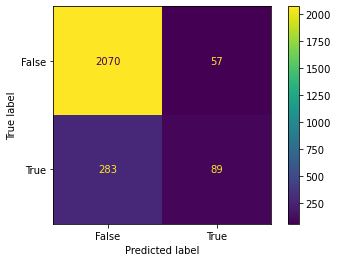

In [23]:
plot_confusion_matrix(baseline_model, X_train, y_train);

We can see that the baseline model usually just predicts that the customer is not going to leave, and since about 85% of customers stay, the model can just always say the customer will stay and be right 85% of the time. From the confusion matrix above, we can see that our test only found 3 customers that were likely to leave, and missed 98 customers that were likely to leave. This is further supported by a low recall score.

We want our model to minimize false negatives (in this case, the model predicting that a customer will not leave when the customer will leave). While we also want to reduce false positives (predicting that a customer will leave when they are unlikely to), it is not as important since our solutions will likely be reaching out to at risk customers to ensure they are happy with our service, which should not necessarily make happy customers want to leave.

To start, we will make a function with two purposes:
1. Give scores for a our training data.
2. Cross validate the scores to catch overfitting early.

In [24]:
# Create Function with Report
def model_report(model, X_train, y_train, lst, sample_set, model_name):
    """
    Function to fit and test a Classification Model, generate metrics and store them in a list.

    Args:
        model(sklearn.model): Instance of a Classification Model.
        X_train(pandas.DataFrame or pandas.Series): Contains the training set of independent variables.
        X_test(pandas.DataFrame or pandas.Series): Contains the test set of independent variables.
        y_train(pandas.DataFrame or pandas.Series): Contains the training set of the dependent variable.
        y_test(pandas.DataFrame or pandas.Series): Contains the test set of the dependent variable.
        lst(list): List to store metrics.
        sample_set(str): Custom data set name to able to identify the model's performance.
        model_name(str): Custom Model Name to be able to identify the model on the list.
        
    Return:
        model(sklearn.model): Trained model instance
    """
    # Train Model
    model.fit(X_train, y_train)

    # Predict
    y_hat_train = model.predict(X_train)

    # Confusion Matrix
    conf_matrix_train = confusion_matrix(y_train, y_hat_train)
    
    # True/False Positive/Negative
    tn_train = conf_matrix_train[0][0]
    fp_train = conf_matrix_train[0][1]
    fn_train = conf_matrix_train[1][0]
    tp_train = conf_matrix_train[1][1]

    # Calculate Metrics
    ps_train = round(precision_score(y_train, y_hat_train), 2)
    rs_train = round(recall_score(y_train, y_hat_train), 2)
    acc_train = round(accuracy_score(y_train, y_hat_train), 2)
    f1_train = round(f1_score(y_train, y_hat_train), 2)
    neg_pred_train = round((fn_train / (fn_train + fp_train)), 2)
    
    # Cross Validation
    scoring = {'acc': 'accuracy', 'prec': 'precision','rec': 'recall'}
    
    cv_scores = cross_validate(model,
                               X_train, y_train,
                               scoring = scoring,
                                cv=5,
                              return_train_score=True)
    
    # Append Results to lst
    lst.append([ps_train, rs_train, acc_train, f1_train, neg_pred_train, \
                tn_train, fn_train, fp_train, tp_train, sample_set, model_name, 'train'])
    
    # Print Report
    print(f'Train \nPrecision: {ps_train} | Recall: {rs_train} | Accuracy: {acc_train}')
    print(f'F1-Score: {f1_train} | Neg Predictive: {neg_pred_train}')
    print('Confusion Matrix\n', conf_matrix_train)
    print('')
    print(f"CV \nPrecision: {cv_scores['test_prec'].mean():2f} | Recall: {cv_scores['test_rec'].mean()} | Accuracy: {cv_scores['test_acc'].mean()}")
    
    return model

# Create Empty List to Store metrics
model_results = []

As discussed before, there is a class imbalance for our target (~85% do not churn, ~15% do churn). We can offset this imbalance using SMOTE, which will sythesize data for our minority class.

Note: this is not the same as making up data. SMOTE creates data that is similar to that found in our minority class.

In [25]:
# Create instance of smote
smote = SMOTE(random_state=123)

# Create resampled version of the train dataset
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

With our function in place, we can do initial checks for multiple different types of models. We will give them a try on our original training data and SMOTE training data. The expectation is that SMOTE will preform better, but we will check both just to be safe.

### Logistic Regression

In [26]:
# Instantiate LogisticRegression
logreg = LogisticRegression(fit_intercept=False, C=1e20, solver='liblinear', random_state=123)

# Generate Report
logreg_baseline = model_report(logreg, X_train, y_train, model_results, 'baseline', 'log_reg')

Train 
Precision: 0.28 | Recall: 0.85 | Accuracy: 0.66
F1-Score: 0.43 | Neg Predictive: 0.06
Confusion Matrix
 [[1329  798]
 [  54  318]]

CV 
Precision: 0.255338 | Recall: 0.8197837837837838 | Accuracy: 0.6174460921843687


In [27]:
# Resampled + Normalized + Scaled Features
log_reg_resampled = model_report(logreg, X_train_resampled, y_train_resampled, 
                                 model_results, 'resampled', 'log_reg')

Train 
Precision: 0.69 | Recall: 0.93 | Accuracy: 0.76
F1-Score: 0.8 | Neg Predictive: 0.14
Confusion Matrix
 [[1258  869]
 [ 147 1980]]

CV 
Precision: 0.686891 | Recall: 0.9257056061861364 | Accuracy: 0.7517638764083777


### K Nearest Neighbors

In [28]:
knn_cl = KNeighborsClassifier(n_neighbors=5)
# Scaled Features
knn_scaled = model_report(knn_cl, X_train, y_train, model_results, 'scaled', 'knn')

Train 
Precision: 0.85 | Recall: 0.16 | Accuracy: 0.87
F1-Score: 0.27 | Neg Predictive: 0.97
Confusion Matrix
 [[2116   11]
 [ 311   61]]

CV 
Precision: 0.483838 | Recall: 0.0483963963963964 | Accuracy: 0.8495414829659318


In [29]:
knn_resampled = model_report(knn_cl, X_train_resampled, y_train_resampled, model_results, 'resampled', 'knn')

Train 
Precision: 0.84 | Recall: 0.99 | Accuracy: 0.9
F1-Score: 0.91 | Neg Predictive: 0.03
Confusion Matrix
 [[1719  408]
 [  13 2114]]

CV 
Precision: 0.772496 | Recall: 0.9764838442419222 | Accuracy: 0.8443812815372918


### Decision Tree

In [30]:
# Different Hyperparameters
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': list(range(1,6)),
              'max_features': [20, 40, 60, None]}

# Try Different Hyperparameters
dt_clf = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, n_jobs=-1, scoring='recall')

In [31]:
# Scaled Features
dt_clf_scaled = model_report(dt_clf, X_train, y_train,
                               model_results, 'scaled', 'dt')

Train 
Precision: 0.95 | Recall: 0.73 | Accuracy: 0.95
F1-Score: 0.83 | Neg Predictive: 0.88
Confusion Matrix
 [[2113   14]
 [ 100  272]]

CV 
Precision: 0.865530 | Recall: 0.71790990990991 | Accuracy: 0.9411751503006013


In [32]:
# Resampled + Normalized + Scaled Features
dt_clf_resampled = model_report(dt_clf, X_train_resampled, y_train_resampled, 
                                  model_results, 'resampled', 'dt')

Train 
Precision: 0.85 | Recall: 0.85 | Accuracy: 0.85
F1-Score: 0.85 | Neg Predictive: 0.51
Confusion Matrix
 [[1811  316]
 [ 324 1803]]

CV 
Precision: 0.791966 | Recall: 0.7940336923501795 | Accuracy: 0.7705815995023155


### Random Forrest

In [33]:
# Different Hyperparameters
param_grid = {'n_estimators': [30, 50],
              'criterion': ['entropy', 'gini'],
              'min_samples_leaf': [5]}

# Try Different Hyperparameters
rf_clf = GridSearchCV(RandomForestClassifier(random_state=123), param_grid, 
                           scoring='recall', n_jobs=-1)

In [34]:
# Generate Report
rf_clf_baseline = model_report(rf_clf, X_train, y_train, 
                                    model_results, 'baseline', 'rf')

Train 
Precision: 1.0 | Recall: 0.54 | Accuracy: 0.93
F1-Score: 0.7 | Neg Predictive: 0.99
Confusion Matrix
 [[2126    1]
 [ 171  201]]

CV 
Precision: 0.953409 | Recall: 0.25282882882882884 | Accuracy: 0.8867567134268537


In [35]:
# Resampled + Scaled + Normalized Features
rf_clf_resampled = model_report(rf_clf, X_train_resampled, y_train_resampled, 
                                     model_results, 'resampled', 'rf')

Train 
Precision: 0.97 | Recall: 0.95 | Accuracy: 0.96
F1-Score: 0.96 | Neg Predictive: 0.62
Confusion Matrix
 [[2067   60]
 [  98 2029]]

CV 
Precision: 0.927954 | Recall: 0.8932615299640982 | Accuracy: 0.9113817653971108


### XG Boost

In [36]:
# Create Model Instance
xgbc_clf = XGBClassifier(random_state=42)

In [37]:
# Generate Report
xgbc_clf_baseline = model_report(xgbc_clf, X_train, y_train, 
                                    model_results, 'baseline', 'xgbc')

Train 
Precision: 1.0 | Recall: 1.0 | Accuracy: 1.0
F1-Score: 1.0 | Neg Predictive: nan
Confusion Matrix
 [[2127    0]
 [   0  372]]

CV 
Precision: 0.917976 | Recall: 0.7420540540540541 | Accuracy: 0.951580761523046


In [38]:
# Resampled + Scaled Features
xgbc_clf_resampled = model_report(xgbc_clf, X_train_resampled, y_train_resampled, 
                                     model_results, 'resampled', 'xgbc')

Train 
Precision: 1.0 | Recall: 1.0 | Accuracy: 1.0
F1-Score: 1.0 | Neg Predictive: nan
Confusion Matrix
 [[2127    0]
 [   0 2127]]

CV 
Precision: 0.977259 | Recall: 0.9068290527478597 | Accuracy: 0.9424151517246147


### Winner: XG Boost

XG Boost seems to have performed the best with a Cross Validation recall of 91%. While K Nearest Neighbors had a recall of 98%, it sacrificed a lot of precision and accuracy. We decided that recall is our most important measurement, but we do not want the expense to overall accuracy to be too big. XG Boost seems to give the best balance.

The next step is setting up a grid search to find the the best parameters to use for our model. The reason we do not simply do this for all of our models is because it can be computationally expensive, so we need to be a bit selective on what models we choose.

In [39]:
# Different Hyperparameters
param_grid = {'max_depth' : [4, 6, 8],
             'learning_rate' : [.1, .01, .001],
              'min_child_weight' : [1, 5, 10],
              'booster' : ['gbtree', 'gblinear', 'dart']
             }

# Try Different Hyperparameters
xgbc_new = GridSearchCV(XGBClassifier(random_state=42), param_grid, n_jobs=-1, scoring='recall')

In [40]:
# Train new model
xgbc_new_gs = model_report(xgbc_new, X_train_resampled, y_train_resampled, 
                             model_results, 'res_scaled_optimized', 'xgbc')

Train 
Precision: 1.0 | Recall: 0.99 | Accuracy: 1.0
F1-Score: 1.0 | Neg Predictive: 1.0
Confusion Matrix
 [[2127    0]
 [  19 2108]]

CV 
Precision: 0.973829 | Recall: 0.9171864125932062 | Accuracy: 0.9457045690191471


In [41]:
# Best Hyperparameters
xgbc_new.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 1}

In [42]:
xgbc_final = XGBClassifier(booster='gbtree', learning_rate = .1, max_depth=8, min_child_weight=1)

xgbc_final.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
xgbc_final.score(X_train_resampled, y_train_resampled)

0.9955336154207804

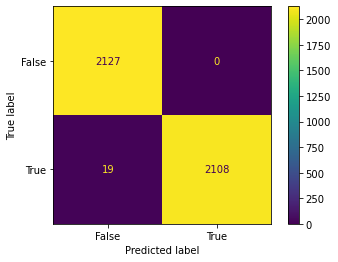

In [44]:
plot_confusion_matrix(xgbc_final, X_train_resampled, y_train_resampled);

Using the parameters from our gridsearch, we create our final model. It seems to have performed extremely well on our test data. According to our confusion matrix, 2113 churned customers were identified, and only 14 were missed!
We can now look at our test data to see how our model does on unseen data. 

In [45]:
y_test_hat = xgbc_final.predict(X_test)

print("Recall: " , recall_score(y_test, y_test_hat))
print("Accuracy: " , accuracy_score(y_test, y_test_hat))
print("Precision: " , precision_score(y_test, y_test_hat))

Recall:  0.8468468468468469
Accuracy:  0.9628297362110312
Precision:  0.8703703703703703


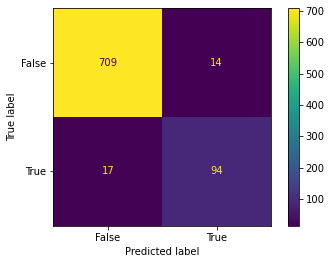

In [46]:
plot_confusion_matrix(xgbc_final, X_test, y_test);

While the model is a bit lower on our test data, we can see a massive improvement in recall. Our model identified 92 churn customers, and only missed 19. For now, this model should prove sufficient to help reduce churn rate. The last thing we want to do is check our model to see what features seemed to have the largest impact.

In [47]:
# Create List with Feature Name and Weight
features_lst = []
for i in zip(list(X_train_resampled.columns), xgbc_new.best_estimator_.feature_importances_):
    features_lst.append(i)

# Create Dataframe and sort values to plot
xgb_features = pd.DataFrame(features_lst, columns=['feature', 'weight'])
xgb_features = xgb_features.sort_values('weight').reset_index(drop=True)
xgb_features = xgb_features.nlargest(20, 'weight')
xgb_features

,feature,weight
62,international_plan_yes,0.144220
61,voice_mail_plan_yes,0.115826
60,customer_service_calls,0.089459
59,number_vmail_messages,0.056518
58,total_day_charge,0.051725
57,state_MS,0.042279
56,total_intl_calls,0.024222
55,total_eve_charge,0.022367
54,state_WY,0.021553
53,state_OH,0.020492


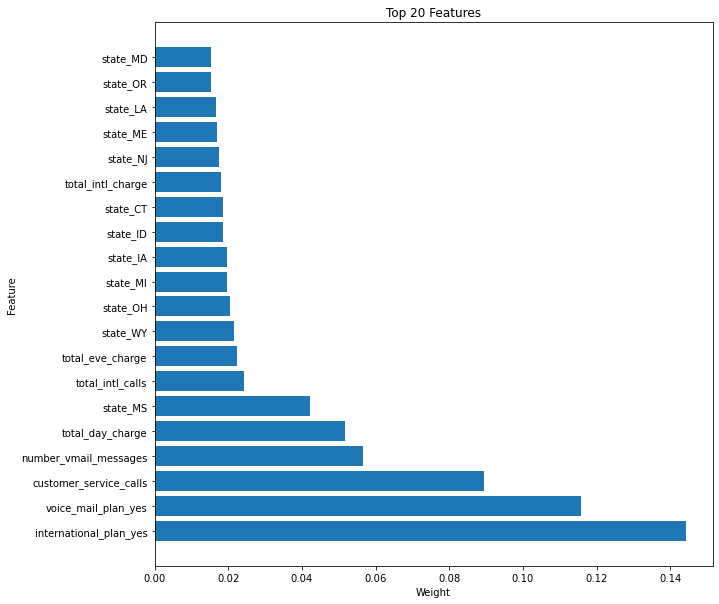

In [48]:
fig, ax = plt.subplots(figsize=(10,10))

ax.barh(xgb_features['feature'], xgb_features['weight'])
ax.set_title('Top 20 Features')
ax.set_xlabel('Weight')
ax.set_ylabel('Feature');

# Conclusion

Using the data provided, we were able to create a model with 85% recall, meaning of the customers who are going to leave, we are able to identify 85% of them. We were able to do this while maintining a high accuracy of 95%. 

Based on the feature importance we can determine that churn can be influenced by:
1. If the customer has an international plan
2. Voice mail plan and number of voicemail messages
3. Customer Service Calls
4. Total day charge

We can also see that a lot of states seemed to have made it into the top 20. Based on this information, we would recommend the following:

1. Further investigation into needs of international plan customers. Consider if there is a move to online forms of communication for international users (Skype, Discord, Google Chat, FaceTime). See if more robust dataplans can be used
2. Audit Customer Service Calls. Make sure cusotmers are being helped. If the model identifies a customer likely to leave, it may be worth checking if they have called in recently.
3. Check to make sure rates are competitive in a given area. With total day charge as a significant factor in our model, it is worth making sure that rates are competitve, especially in states with higher churn.

Finally, moving forward we can do the following:
1. Fix issue with area code data. This can help us determine geographic churn at a more granular level. (Worth noting that since these are not landlines there is not a 100% relation to customer area and area code, but can still be good for approximation).
2. Look into call center statistics. Currently we only know how many times a customer may have called, but we should try to get more information such as customer satisfaction, call time, need for escalation, etc.
3. Get more information about customer accounts. Currently we only have call data, we should know more about texting and data options as well. We can also see how many lines are on a given account.